# Gradient Boosting Classifier

---

__This Notebook__

- implement sklearn.ensemble.GradientBoostingClassifier

__Results__ 

- 



## Setup

In [1]:
import re
import os
import time
import joblib 

import numpy as np
import pandas as pd
import scipy.sparse as sp
import matplotlib.pyplot as plt

from datetime import datetime
from sklearn.metrics import confusion_matrix

dt_object = datetime.fromtimestamp(time.time())
day, T = str(dt_object).split('.')[0].split(' ')
print('Revised on: ' + day)

Revised on: 2021-02-09


## Load

In [2]:
# load target vector
raw_path = os.path.join("data","1_raw")
y_df = pd.read_csv(os.path.join(raw_path, 'y_train.csv'))
y_array = np.array(y_df.iloc[:,0].ravel())

y = y_array.copy()

# transform y_array into int type
y[y=='ham'] = 0
y[y=='spam'] = 1
y = y.astype('int')

# load matrix
proc_dir = os.path.join("data", "2_processed")
X_tfidf_svd800_spamcos = sp.load_npz(os.path.join(proc_dir, 'X_tfidf_svd800_spamcos.npz'))

## Helpful Functions


In [3]:
# train classifier and time it
def time_deco(func):
    def wrapper(clf):
        start = time.time()
        func(clf)
        m,s = divmod(time.time() - start, 60)
        print(f'Elapsed: {m:0.0f}m {s:0.0f}s')
    return wrapper

@time_deco
def fit_clf(clf):
    clf.fit(X_train, y_train)
    
# evaluate classifier
def eval_clf(y_val, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_val, 
                                      y_pred).ravel()
    confmat_df = pd.DataFrame(
        np.array(([tn, fp], [fn, tp])),
        columns=['pred_neg', 'pred_pos'], 
        index=['cond_neg', 'cond_pos']
    )
    # unpack metrics
    acc = (tp + tn) / (tp + tn + fp + fn)
    tpr = tp / (tp + fn)
    tnr = tn / (tn + fp)
    # print results
    print(confmat_df)
    print(f'acc: {acc:0.4f}')
    print(f'tpr: {tpr:0.4f}')
    print(f'tnr: {tnr:0.4f}')

def extract_df(gd):
    gd_res = gd.cv_results_
    df = pd.concat([
                    pd.DataFrame(gd_res["params"]),
                    pd.DataFrame(gd_res["mean_train_acc"], columns=["mean_train_acc"]),
                    pd.DataFrame(gd_res["mean_train_tpr"], columns=["mean_train_tpr"]),
                    pd.DataFrame(gd_res["mean_train_tnr"], columns=["mean_train_tnr"]),
                    pd.DataFrame(gd_res["mean_test_acc"], columns=["mean_val_acc"]),
                    pd.DataFrame(gd_res["mean_test_tpr"], columns=["mean_val_tpr"]),
                    pd.DataFrame(gd_res["mean_test_tnr"], columns=["mean_val_tnr"]),
                    pd.DataFrame(gd_res["mean_fit_time"], columns=["mean_fit_time"])
                    #pd.DataFrame(gd_res["std_test_acc"], columns=["std_val_acc"]),
                    #pd.DataFrame(gd_res["std_test_tpr"], columns=["std_val_tpr"]),
                    #pd.DataFrame(gd_res["std_test_tnr"], columns=["std_val_tnr"]),
                   ]
                   , axis=1)
    return df

### Train Test Split

##  Gradient Boosting Classifier


```
class GradientBoostingClassifier(ClassifierMixin, BaseGradientBoosting):
    """Gradient Boosting for classification.
    GB builds an additive model in a
    forward stage-wise fashion; it allows for the optimization of
    arbitrary differentiable loss functions. In each stage ``n_classes_``
    regression trees are fit on the negative gradient of the
    binomial or multinomial deviance loss function. Binary classification
    is a special case where only a single regression tree is induced.
```

See [docs](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html), [code](https://github.com/scikit-learn/scikit-learn/blob/95119c13a/sklearn/ensemble/_gb.py#L768)

__Some defaults:__


- `loss='deviance'`
- `learning_rate=0.1`
- `n_estimators=100`
- `subsample=1.0`
- `criterion='friedman_mse'`
- `min_samples_split=2`
- `min_samples_leaf=1`
- `min_weight_fraction_leaf=0.0`
- `max_depth=3`
- `min_impurity_decrease=0.0`
- `min_impurity_split=None`
- `init=None`
- `random_state=None`
- `max_features=None`
- `verbose=0`
- `max_leaf_nodes=None`
- `warm_start=False`
- `validation_fraction=0.1`
- `n_iter_no_change=None`
- `tol=0.0001`
- `ccp_alpha=0.0`

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, accuracy_score, recall_score
from sklearn.ensemble import GradientBoostingClassifier

In [5]:
X_train, X_val, y_train, y_val = train_test_split(X_tfidf_svd800_spamcos,
                                                  y, 
                                                  stratify=y,
                                                  random_state=42)

In [6]:
gb_clf = GradientBoostingClassifier(
    random_state=42
    , verbose=1
)

In [7]:
gb_clf.fit(X_train, y_train)

      Iter       Train Loss   Remaining Time 
         1           0.5988            2.47m
         2           0.5007            2.40m
         3           0.4298            2.37m
         4           0.3746            2.35m
         5           0.3297            2.32m
         6           0.2921            2.29m
         7           0.2597            2.26m
         8           0.2322            2.24m
         9           0.2079            2.21m
        10           0.1869            2.19m
        20           0.0696            1.94m
        30           0.0285            1.71m
        40           0.0138            1.46m
        50           0.0078            1.21m
        60           0.0054           58.15s
        70           0.0044           43.73s
        80           0.0036           29.05s
        90           0.0031           14.48s
       100           0.0026            0.00s


GradientBoostingClassifier(random_state=42, verbose=1)

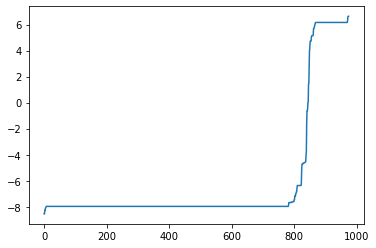

In [8]:
# evaluate using decision function
y_score = gb_clf.decision_function(X_val)
plt.plot(sorted(y_score))
plt.show()

In [9]:
# default threshold
thresh = 0
y_pred = np.where(y_score > thresh, 1, 0)
eval_clf(y_val, y_pred)

          pred_neg  pred_pos
cond_neg       842         4
cond_pos         2       127
acc: 0.9938
tpr: 0.9845
tnr: 0.9953


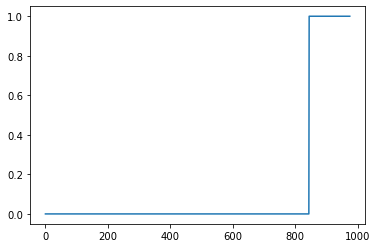

In [10]:
y_pred = gb_clf.predict(X_val)
plt.plot(sorted(y_pred))
plt.show()

In [11]:
eval_clf(y_val, y_pred)

          pred_neg  pred_pos
cond_neg       842         4
cond_pos         2       127
acc: 0.9938
tpr: 0.9845
tnr: 0.9953


## GridSearchCV

In [12]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, accuracy_score, recall_score
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier

def gridsearch_wrapper(X, y, param_grid, k=5, n_jobs=6):
    """
    Performs a grid search with
    Args:
        X: numeric matrix
        y: target variable
        param_grid : dict of hyperparameters for search
        k: number of CV folds
        n_jobs: number of logical cores
    """
    start_time = time.time()

    # split into training and validation sets
    X_train, X_val, y_train, y_val = train_test_split(X, 
                                                      y, 
                                                      stratify=y,
                                                      random_state=42)

    # setup scorers
    scorers = {
        'acc': make_scorer(accuracy_score),
        'tpr': make_scorer(recall_score, pos_label=1), # sensitivity, recall
        'tnr': make_scorer(recall_score, pos_label=0) # specificity, selectivity
    }

    # instantiate estimator
    clf =  GradientBoostingClassifier(
        random_state=42
    )

    # instantiate k-fold gridsearch
    cv_folds = StratifiedKFold(n_splits=k)
    
    grid_search_clf = GridSearchCV(clf, 
                                   param_grid,
                                   scoring=scorers, 
                                   refit='tpr', 
                                   cv=cv_folds, 
                                   return_train_score=True, 
                                   n_jobs=n_jobs,
                                   verbose=1)
    
    # train models
    grid_search_clf.fit(X_train, y_train)

    # predict
    y_pred = grid_search_clf.predict(X_val)
    print(f'Best params: {grid_search_clf.best_params_}')

    # eval metrics
    print('Evaluation metrics:')
    eval_clf(y_val, y_pred)
    
    return grid_search_clf

In [16]:
test_params = {
    'n_estimators': [10, 25],
    'learning_rate': [.1, 1],
    'max_depth': [1, 2, 3]
}

params = {
    'n_estimators': [10, 50, 100],
    'learning_rate': [.001, .01, .1, 1],
    'max_depth': [1, 2, 3]
}

In [17]:
gridsearch_clf = gridsearch_wrapper(X_tfidf_svd800_spamcos,
                                    y, 
                                    test_params,
                                    k=10,                        
                                    n_jobs=-1)

Fitting 10 folds for each of 12 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:  5.9min finished


Best params: {'learning_rate': 0.1, 'max_depth': 1, 'n_estimators': 25}
Evaluation metrics:
          pred_neg  pred_pos
cond_neg       839         7
cond_pos         2       127
acc: 0.9908
tpr: 0.9845
tnr: 0.9917


In [18]:
df = extract_df(gridsearch_clf)
df.sort_values(by=['mean_val_tpr'], ascending=False)

,learning_rate,max_depth,n_estimators,mean_train_acc,mean_train_tpr,mean_train_tnr,mean_val_acc,mean_val_tpr,mean_val_tnr,mean_fit_time
1,0.1,1,25,0.994644,0.975659,0.997547,0.993157,0.969096,0.996849,16.131887
5,0.1,3,25,0.998822,0.991122,1.000000,0.992474,0.969096,0.996060,47.023306
6,1.0,1,10,0.995214,0.982532,0.997153,0.991449,0.969096,0.994879,6.850760
7,1.0,1,25,0.995251,0.982532,0.997197,0.991449,0.969096,0.994879,16.830054
3,0.1,2,25,0.997227,0.979957,0.999869,0.992473,0.966532,0.996454,30.856894
0,0.1,1,10,0.994606,0.967352,0.998774,0.993499,0.963968,0.998030,6.669920
4,0.1,3,10,0.997455,0.980814,1.000000,0.993841,0.963968,0.998422,18.596509
10,1.0,3,10,1.000000,1.000000,1.000000,0.989741,0.963968,0.993693,18.580140
11,1.0,3,25,1.000000,1.000000,1.000000,0.989741,0.963968,0.993695,44.552344
8,1.0,2,10,0.998405,0.997421,0.998555,0.985975,0.958772,0.990139,13.032878


### Early Stopping

`
IN PROGRESS....
`

In [19]:
X_train, X_val, y_train, y_val = train_test_split(X_tfidf_svd800_spamcos, y, stratify=y)
gb_clf = GradientBoostingClassifier(max_depth=1)

In [32]:
max_val_recall = 1.0
recall_not_going_up = 0.0

for n_estimators in range(1, 100):
    gb_clf.n_estimators = n_estimators
    gb_clf.fit(X_train, y_train)
    y_pred = gb_clf.predict(X_val)
    recall = recall_score(y_val, y_pred)
    
    print(f'n_estimators: {n_estimators:0.0f}')
    print(f'recall: {recall:0.4f}')
    print(f'max_val_recall: {max_val_recall:0.4f}')
    
    if recall < max_val_recall:
        print('Recall not going up')
        recall_not_going_up += 1
        max_val_recall = recall
        print(f'recall_not_going_up: {recall_not_going_up:0.4f}\n')
        if recall_not_going_up == 5:
            gb_clf.n_estimators_ = n_estimators-5
            print(f'best_n_estimators: {n_estimators-5:0.0f}')
            break
    elif recall == max_val_recall:
        print('Recall stabilizing')
        recall_not_going_up += 1
        max_val_recall = recall
        print(f'recall_not_going_up: {recall_not_going_up:0.4f}\n')
        if recall_not_going_up == 5:
            gb_clf.n_estimators_ = n_estimators-5
            print(f'best_n_estimators: {n_estimators-5:0.0f}')
            break
    else:
        print('Recall going up')
        recall_not_going_up = 0
        max_val_recall = recall
        print(f'recall_not_going_up: {recall_not_going_up:0.4f}\n')

n_estimators: 1
recall: 0.0000
max_val_recall: 1.0000
Recall not going up
recall_not_going_up: 1.0000

n_estimators: 2
recall: 0.0000
max_val_recall: 0.0000
Recall stabilizing
recall_not_going_up: 2.0000

n_estimators: 3
recall: 0.0000
max_val_recall: 0.0000
Recall stabilizing
recall_not_going_up: 3.0000

n_estimators: 4
recall: 0.0000
max_val_recall: 0.0000
Recall stabilizing
recall_not_going_up: 4.0000

n_estimators: 5
recall: 0.9457
max_val_recall: 0.0000
Recall going up
recall_not_going_up: 0.0000

n_estimators: 6
recall: 0.9457
max_val_recall: 0.9457
Recall stabilizing
recall_not_going_up: 1.0000

n_estimators: 7
recall: 0.9690
max_val_recall: 0.9457
Recall going up
recall_not_going_up: 0.0000

n_estimators: 8
recall: 0.9690
max_val_recall: 0.9690
Recall stabilizing
recall_not_going_up: 1.0000

n_estimators: 9
recall: 0.9690
max_val_recall: 0.9690
Recall stabilizing
recall_not_going_up: 2.0000

n_estimators: 10
recall: 0.9690
max_val_recall: 0.9690
Recall stabilizing
recall_not_go

In [33]:
gb_clf.n_estimators_

7

In [34]:
y_pred = gb_clf.predict(X_val)
eval_clf(y_val, y_pred)

          pred_neg  pred_pos
cond_neg       846         0
cond_pos         4       125
acc: 0.9959
tpr: 0.9690
tnr: 1.0000


---